# Oral Cancer Detection
First we import required libraries (most for Deep Learning & Image Processing), then carry out preprocessing, building our model, post-processing, and prediction.


**Unpack zip file & Import required libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import io
import numpy as np
import cv2 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

zip_path = ".../Oral Cancer.zip"
image_list = []

# Openning the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    img_files = [f for f in zip_file.namelist() if f.endswith(('.png', '.jpg', '.jpeg'))]
    for img_name in img_files:
        with zip_file.open(img_name) as img_file:
            img_bytes = img_file.read()
            img_array = np.frombuffer(img_bytes, np.uint8)
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)     # Convert to NumPy 
            img = cv2.resize(img, (128, 128))                   # Resize to 128x128 (pixels)
            img = img / 255.0  
            image_list.append(img)
# Convert list to NumPy array
dataset = np.array(image_list, dtype=np.float32)  
np.save(".../Oral_Cancer_image_dataset.npy", dataset)
print("Dataset shape:", dataset.shape)


Dataset shape: (750, 128, 128, 3)


# Plot some samples (and their class)

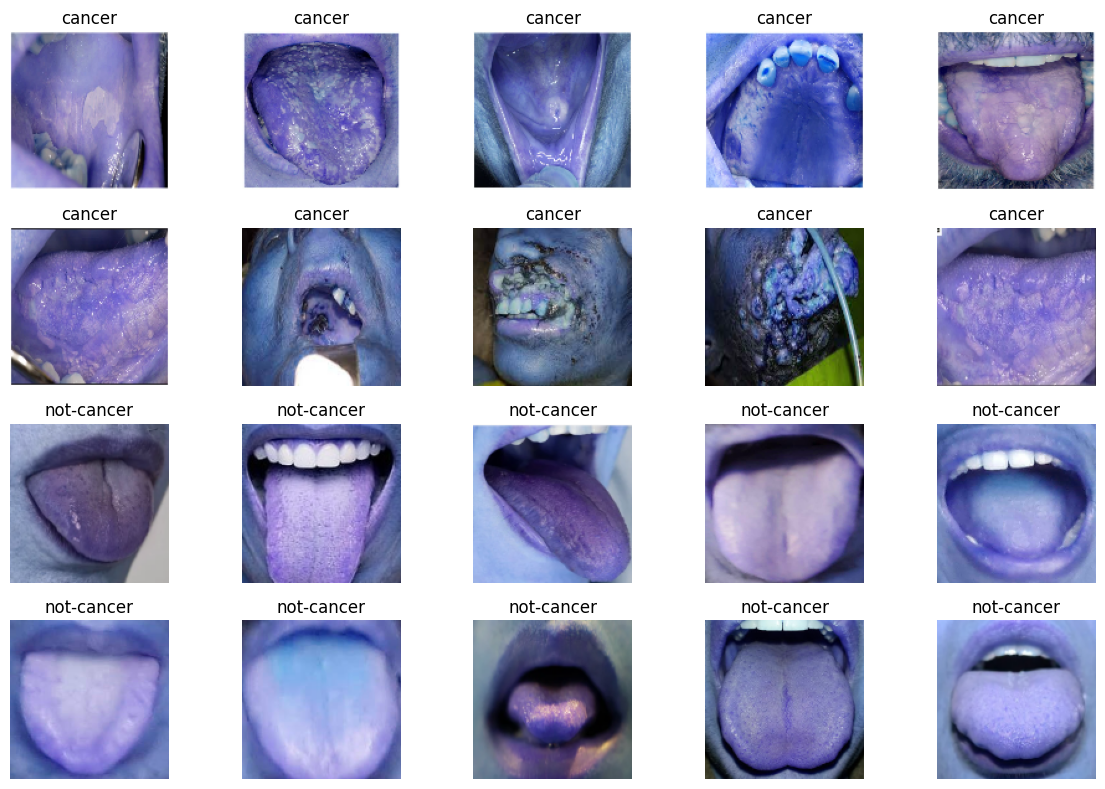

In [ ]:
dataset = np.load(".../Oral_Cancer_image_dataset.npy")
# Note: 
# Cancer        --> From 0 to 500
# Not-cancer    --> From 500 to 750
Labels = np.concatenate((np.repeat(1, 500), np.repeat(0, 250)))
lab = {0:'not-cancer', 1: 'cancer'}
fig, axes = plt.subplots(4, 5, figsize=(12, 8)) 
for i, ax in enumerate(axes.flat):
    ax.imshow(dataset[490:510][i]) 
    ax.set_title(lab.get(Labels[490:510][i])) 
    ax.axis('off')  
plt.tight_layout()
plt.show()


# Dataset

**There are two main issues. First, our dataset lacks a proper balance between cancer and not-cancer images (unbalanced classes). It tends to a kind of bias for our model to prone to the larger class. Second, our data is really limited, need to be expanded by some appropriate method. Random noise can be the first option to try**

In [ ]:
# First, try to solve the unbalancing issue
X_cancer = dataset[:500]       # First 500 images (Cancer)
X_not_cancer = dataset[500:]   # Last 250 images (Not Cancer)

# Duplicate Not Cancer images to get 500 images
X_not_cancer_augmented = np.tile(X_not_cancer, (2, 1, 1, 1))  # Now (500, 128, 128, 3)

# Add slight noise (Gaussian noise)
noise_factor = 0.02  # Adjust the noise level as needed
noise = np.random.normal(loc=0, scale=noise_factor, size=X_not_cancer_augmented.shape)
X_not_cancer_augmented = np.clip(X_not_cancer_augmented + noise, 0, 1)  # Keep values in range [0,1]
X_balanced = np.concatenate([X_cancer, X_not_cancer_augmented], axis=0)
print("New dataset shape:", X_balanced.shape)  

New dataset shape: (1000, 128, 128, 3)


# Plotting some noisy images

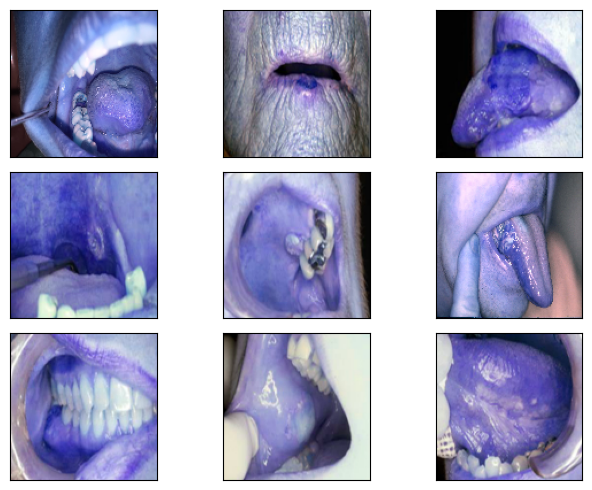

In [ ]:
f, ax = plt.subplots(3,3, figsize=(7,5))
for i in range(9):
    ax[i//3, i%3].imshow(X_balanced[i])
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
X = X_balanced
y = np.concatenate((np.repeat(0, 250), Labels))
print(f"Dataset shape: {X.shape}\nTarget shape: {y.shape}")

Dataset shape: (1000, 128, 128, 3)
Target shape: (1000,)


# Try to augment our data

In [ ]:

def augment_images(images, copies=3, noise_factor=0.02):
    augmented_images = [images]  
    for _ in range(copies):
        noise = np.random.normal(loc=0, scale=noise_factor, size=images.shape)
        noisy_images = np.clip(images + noise, 0, 1)  
        augmented_images.append(noisy_images)
    return np.concatenate(augmented_images, axis=0)

# Generate 2000 Cancer and 2000 Not Cancer images
X_cancer_augmented = augment_images(X[:500], copies=3)      # 500 * 4 = 2000
X_not_cancer_augmented = augment_images(X[500:], copies=3)  # 500 * 4 = 2000
X_final = np.concatenate([X_cancer_augmented, X_not_cancer_augmented], axis=0)
print("New dataset shape:", X_final.shape)  
X = X_final
y = np.concatenate((np.repeat(1, 2000), np.repeat(0, 2000)))

New dataset shape: (4000, 128, 128, 3)


# Preprocessing (Splitting)

In [9]:

# Splitting into train, validation, and test sets (70%-15%-15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Building dataset pipeline (by Tensorflow)

In [10]:
import tensorflow as tf
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)
print(f"Length of Datasets:\nTrain: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}")
print("="*50)
for x, labels in train_dataset.take(1):
    print(x.shape, labels.shape)

Length of Datasets:
Train: 88
Validation: 19
Test: 19
(32, 128, 128, 3) (32,)


# Building our CNN model to implement Oral Cancer Detection
To enhance our classification model (due to our limited dataset), we need to use some data augmentation techniques.


In [ ]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
val_dataset   = val_dataset.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
test_dataset  = test_dataset.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))

# Transfer Learning (TL)
Altough we've tried to generate more synthetic data (by random noise), it is more common to utilize a pretrained convnet, 
whose weights are already well-trained, embedding in our own CNN model. Here, we use MobileNetV2 as the pretrained model. Additionally, we actually should not try to update (regularize) the pretrained's weights beacuase they're already fitted. So, we'll freeze them and will focus on our model. 

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import MobileNetV2  # Pretrained model

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
base_model.trainable = False   # freezing

m2oral = Sequential([
    # Data Augmentation
    RandomFlip(mode='horizontal'),
    RandomRotation(factor=0.10),
    RandomZoom(height_factor=0.2),
    base_model,
    # Head
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

m2oral.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
# Obviously, it is a binary classification (yes or no)
m2oral.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# How to prevent overfitting?
ES = EarlyStopping(min_delta = 0.0001, patience = 10, restore_best_weights = True)

log_m2 = m2oral.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=50,
    callbacks=[ES])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.7576 - loss: 0.5500 - val_accuracy: 0.8217 - val_loss: 0.4985
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9093 - loss: 0.2232 - val_accuracy: 0.8383 - val_loss: 0.3996
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9341 - loss: 0.1583 - val_accuracy: 0.9017 - val_loss: 0.2768
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9487 - loss: 0.1314 - val_accuracy: 0.8783 - val_loss: 0.3468
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9489 - loss: 0.1195 - val_accuracy: 0.9083 - val_loss: 0.2341
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9594 - loss: 0.1061 - val_accuracy: 0.9367 - val_loss: 0.1684
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9631 - loss: 0.0929 - val_accuracy: 0.8717 - val_loss: 0.3816
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9565 - loss: 0.1127 - val_accuracy: 0.9100 -

# Our model performance

<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Accuracy Value'>

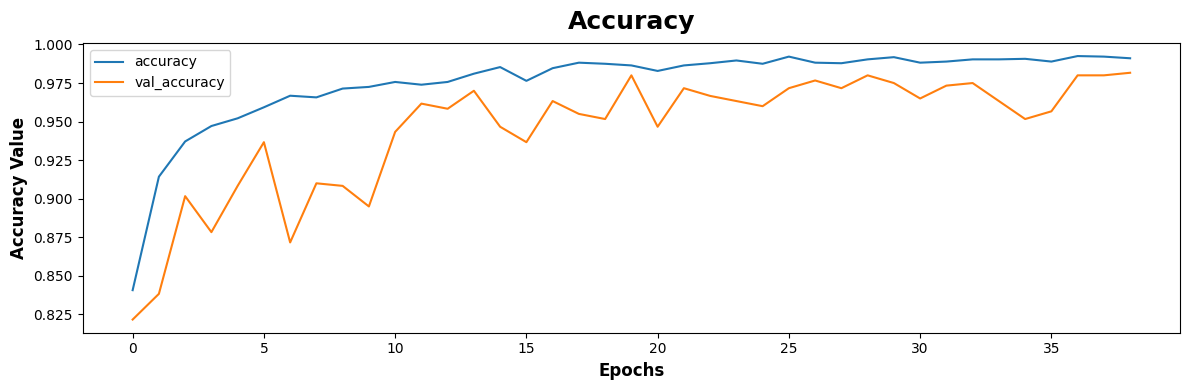

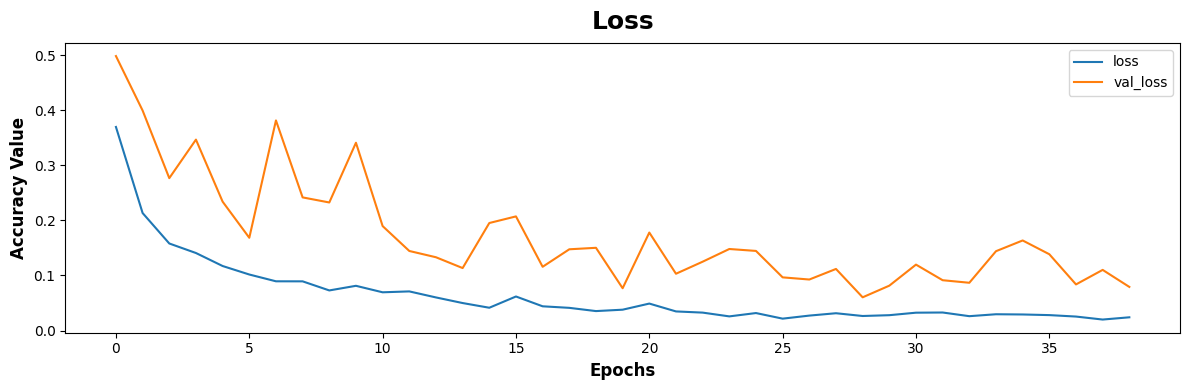

In [23]:
import pandas as pd
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
res_df = pd.DataFrame(log_m2.history)
res_df[['accuracy', 'val_accuracy']].plot(kind = 'line', xlabel='Epochs',
                                                        ylabel='Accuracy Value',
                                                        title='Accuracy',
                                                        figsize=(12, 4))
res_df[['loss', 'val_loss']].plot(kind = 'line', 
                                xlabel='Epochs', 
                                ylabel='Accuracy Value', 
                                title='Loss',
                                figsize=(12, 4))


# Evaluation of m2oral Model

In [24]:
test_loss, test_acc = m2oral.evaluate(test_dataset)
print(f"\n{50*'*'}\nTest Accuracy of our model is (%): {100*test_acc:.2f}")
# model.save("oral_cancer_classifier.h5")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9876 - loss: 0.0391

**************************************************
Test Accuracy of our model is (%): 98.67


# Prediction

In [25]:
y_pred = m2oral.predict(test_dataset)
y_pred.shape

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


(600, 1)

In [26]:
# Unbatching to access the labels (test dataset content)
images, labels = [], []
for image, label in test_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
Te_labels, Te_images = np.array(labels), np.array(images)
arr = np.column_stack((Te_labels, (y_pred > 0.5).astype(int).flatten()))
print(f"\nReport:\nFrom {Te_labels.shape[0]} samples (for prediction), {sum(arr[:, 0] != arr[:, 1])} are incorrectly classified")


Report:
From 600 samples (for prediction), 8 are incorrectly classified


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       277
           1       1.00      0.98      0.99       323

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



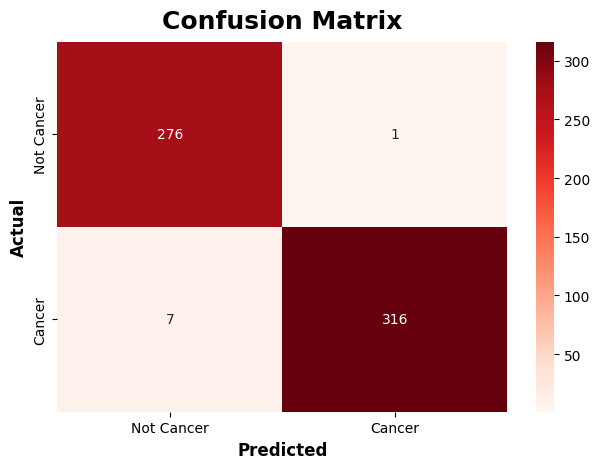

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
print("Classification Report:\n", classification_report(Te_labels, arr[:, 1]))
cm = confusion_matrix(Te_labels, arr[:, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds", xticklabels=["Not Cancer", "Cancer"], yticklabels=["Not Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# True Negative (TN)    = 276:  The number of "Not Cancer" cases correctly predicted as "Not Cancer."
# False Positive (FP)   = 1:    The number of "Not Cancer" cases incorrectly predicted as "Cancer."
# False Negative (FN)   = 7:    The number of "Cancer" cases incorrectly predicted as "Not Cancer."
# True Positive (TP)    = 316:  The number of "Cancer" cases correctly predicted as "Cancer."

# ROC & Precision-Recall

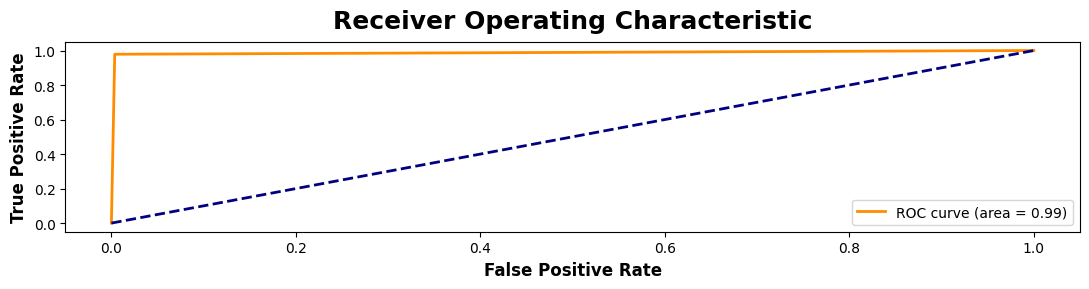

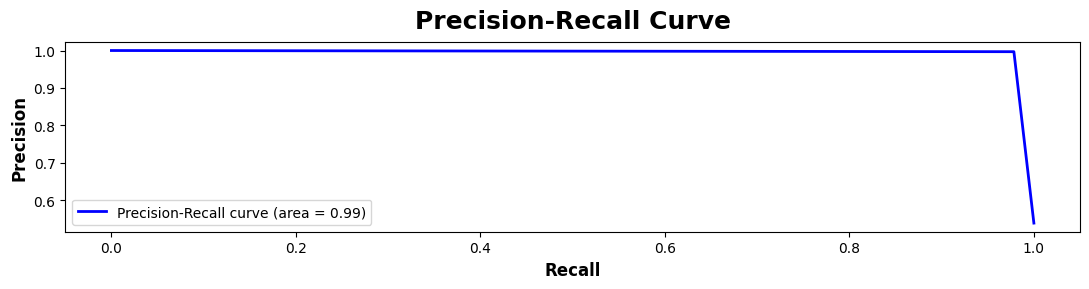

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
fpr, tpr, _ = roc_curve(arr[:, 0], arr[:, 1])
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(arr[:, 0], arr[:, 1])
average_precision = average_precision_score(arr[:, 0], arr[:, 1])

plt.figure(figsize=(11, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(11, 3))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
